In [2]:
!spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 35.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [3]:
import spacy
import pandas as pd 
import numpy as np 
import torch 
import torch.nn as nn 
import torch.optim as optim 
from torchvision import transforms
from torch.utils.data import DataLoader
import nltk 
import re 
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from nltk.stem import PorterStemmer 
import matplotlib.pyplot as plt 
import torch.utils.data as D
import torch.nn.functional as F

In [4]:
# imdb movie review dataset
df = pd.read_csv('/kaggle/input/imdb-dataset/a1_IMDB_Dataset.csv')
df.head()
df.shape

(50000, 2)

In [5]:
df['review'][1]

'A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams\' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master\'s of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional \'dream\' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell\'s murals decorating every surface) are terribly well d

From the above description we should remove 
1. br tag
2. puctuations 
3. stopping words 
4. stemming 


In [6]:
nlp = spacy.load('en_core_web_md')
string = df['review'][1] 

1. convert the label in the pandas to vector 
2. do splitting 
3. for each review collect the vector and do padding and take note of target 

In [7]:

od = OrdinalEncoder()

df['sentiment'] = od.fit_transform(df[['sentiment']])

X_train, X_test, y_train, y_test = train_test_split(df['review'], df['sentiment'], random_state=2, test_size=0.3)


In [8]:
class Text_preprocessor():
    
    
    def __init__(self):
        self.max_length = 0
        self.train_files = []
        self.test_files = []
        
    def preprocess(self, X_train, y_train, train=True):
        '''
        X_train = text or sentence of the review
        y_train = labels in vectorized format
        '''
        
        self.data_to_vector(X_train, y_train, train) # converts the data to vector and removes the data if the sent is zero and save it in a file
        files = self.train_files if train else self.test_files
        if train: # if its train mode view the distribution and fix the pad size else do the padding 
            return self.plot_length(self.train_files) 
        else:
            test_batches = self.data_vec_to_pad(self.test_files) # padd the sentence with zeros so the every rows the same returns the vec as batches

            return test_batches
        
    
    def description_to_vector(self, string):
        string = re.sub('.*?>', '', string)
        tokenizer = nlp(string)
        words = []

        for token in tokenizer:

            if token.is_punct or token.is_stop:
                continue

            if token.has_vector:
                words.append(torch.from_numpy(token.vector))

        if len(words) == 0:
            return [], 0
    
        vectorized = torch.stack(words) 
        return vectorized, len(vectorized)


    def vector_padding(self, arr):
        # the arr rows are words and col is word embeddings of that word 
        # to do add zeros rows so that rows equal to max_size
        row_length, col_length = arr.shape # if the shape is of row and col
        if row_length > self.max_length:
            padded = arr[:self.max_length, :]
        else:
            zero_row_length = self.max_length - row_length
            padded = torch.cat((arr, torch.zeros(zero_row_length, col_length)))
        return padded
    


    def data_to_vector(self, X_train, y_train, train=True):


        vectors = []
        labels = []
        files = []
        file_no = 0


        for idx, i in enumerate(X_train):
            vector, vector_len = self.description_to_vector(i)
            if vector_len > 0:
#                 self.max_length = max(self.max_length, vector_len) 

                vectors.append(vector)
                labels.append(y_train.iloc[idx])

            if (idx+1) % 500 == 0:
                # saves files in 5000 iterations 
                file_no = idx / 5000
                if train:
                    file_no = f'Train_{file_no}'
                vecno = f'/kaggle/working/Vector_{file_no}.pt'

                vectors, labels = vectors, torch.tensor(labels)
                torch.save((vectors, labels), vecno)
                if train:
                    self.train_files.append(vecno)
                else:
                    self.test_files.append(vecno)
                vectors = []
                labels = []


                print(f'----{idx}----')

        if vectors:
            vecno = f'/kaggle/working/Vector_{file_no}_final.pt'

            vectors, labels = vectors, torch.tensor(labels)
            torch.save((vectors, labels), vecno)
            files.append(vecno)
            vectors = []
            labels = []
        print('Finished Vectorizing')
    


    def data_vec_to_pad(self, files):
        x_values = []

        for file in files:
            X, y = torch.load(file)
            for i in range(len(X)):
                X[i] = self.vector_padding(X[i])
            x_values.append((torch.stack(X), y)) # (8, (tuple of total x, total y))

        return x_values


    def plot_length(self, files):
        lengths = []
        print(files)
        for file in files:
            (X, y) = torch.load(file)
            for i in X:
                lengths.append(len(i))
        lengths = np.array(lengths)
        return lengths


        

----499----
----999----
----1499----
----1999----
----2499----
----2999----
----3499----
----3999----
----4499----
----4999----
----5499----
----5999----
----6499----
----6999----
----7499----
----7999----
----8499----
----8999----
----9499----
----9999----
----10499----
----10999----
----11499----
----11999----
----12499----
----12999----
----13499----
----13999----
----14499----
----14999----
----15499----
----15999----
----16499----
----16999----
----17499----
----17999----
----18499----
----18999----
----19499----
----19999----
----20499----
----20999----
----21499----
----21999----
----22499----
----22999----
----23499----
----23999----
----24499----
----24999----
----25499----
----25999----
----26499----
----26999----
----27499----
----27999----
----28499----
----28999----
----29499----
----29999----
----30499----
----30999----
----31499----
----31999----
----32499----
----32999----
----33499----
----33999----
----34499----
----34999----
Finished Vectorizing
['/kaggle/working/Vec

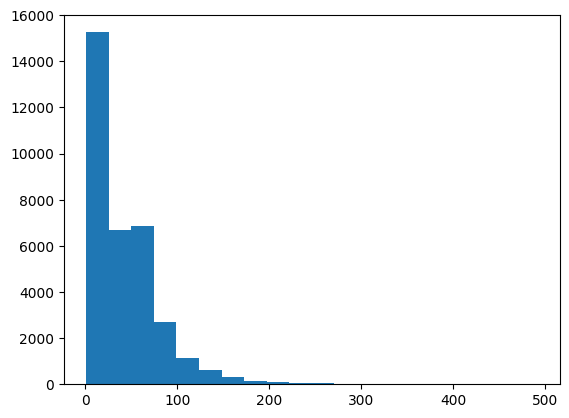

In [9]:
preprocessor = Text_preprocessor()
lengths = preprocessor.preprocess(X_train, y_train, True)
plt.hist(lengths, bins = 20)
plt.show()

In [10]:
# from the observation max_length = 240 for padding 
preprocessor.max_length = 240 # set the padding length
train_batch = preprocessor.data_vec_to_pad(preprocessor.train_files)

In [11]:
train_batch[0][0].shape

torch.Size([494, 240, 300])

In [12]:
# now i have to do the sequence learning based on the sequence_lenth
class RNN(nn.Module):
    def __init__(self, input_size, sequence_length, hidden_size, num_layer=1):
        super().__init__()
        self.input_size = input_size
        self.sequence_length = sequence_length
        self.hidden_size = hidden_size 
        self.num_layer = num_layer
        self.feature_size = 300
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True) # this result in a batch, 300, 500 
        self.fc = nn.Linear(sequence_length*hidden_size, 500)
        self.fc2 = nn.Linear(500, 2)

    def forward(self, x):
        rnn_res, hidden_weights = self.rnn(x)
        reshaped_x = rnn_res.reshape(-1, self.sequence_length*self.hidden_size)
        x = F.relu(self.fc(reshaped_x))
        x = self.fc2(x)
        return x
    



In [13]:
from sklearn.metrics import accuracy_score

def accuracy(model, preprocessed):
    acc = []
    for (X, y) in preprocessed:
        X = X.cuda()
        y = y.type(torch.LongTensor)   
        y = y.cuda()
        
        with torch.no_grad():
            pred = model(X)
            softmaxed = F.softmax(pred, dim=1)
            result = torch.argmax(softmaxed, dim=1)
            cpu_res = result.to('cpu')
            y = y.to('cpu').numpy()
            numpy_res = cpu_res.numpy()
            acc.append(accuracy_score(y, numpy_res))
#     print('Average acc: ', sum(acc) / len(acc))
    return acc 

In [14]:
test_batch = preprocessor.preprocess(X_test, y_test, False)

----499----
----999----
----1499----
----1999----
----2499----
----2999----
----3499----
----3999----
----4499----
----4999----
----5499----
----5999----
----6499----
----6999----
----7499----
----7999----
----8499----
----8999----
----9499----
----9999----
----10499----
----10999----
----11499----
----11999----
----12499----
----12999----
----13499----
----13999----
----14499----
----14999----
Finished Vectorizing


In [15]:

train_acc = []
test_acc = []

criterion = F.cross_entropy
epochs = 40
input_size = 300
hidden_size = 500
sequence_len = 240
model = RNN(input_size, sequence_len, hidden_size).cuda()

optimizer = optim.Adam(model.parameters(), 0.001)


for i in range(epochs):
    for (X, y) in train_batch:
        X = X.cuda()
        y = y.type(torch.LongTensor)   
        y = y.cuda()
        
        optimizer.zero_grad()
        forward = model(X)
        loss = criterion(forward, y)
        loss.backward()
        optimizer.step()
        
    with torch.no_grad():
        acc = accuracy(model, test_batch)
        test_acc.append(sum(acc)/len(acc))
        
        acc = accuracy(model, train_batch)
        train_acc.append(sum(acc)/len(acc))
        
        

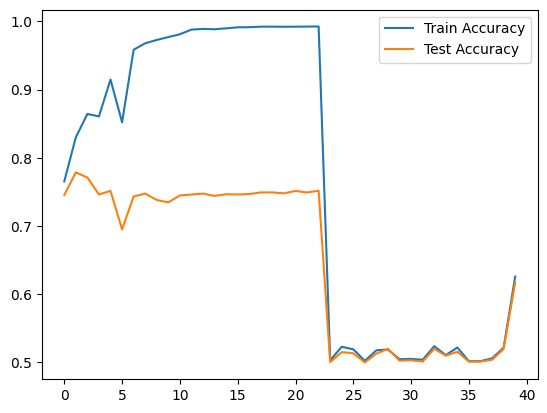

In [16]:
plt.plot(train_acc, label='Train Accuracy')
plt.plot(test_acc, label='Test Accuracy')
plt.legend()
plt.show()

In [17]:
accuracy(model, test_batch)

[0.6257668711656442,
 0.6270491803278688,
 0.6041237113402061,
 0.6402439024390244,
 0.6041237113402061,
 0.6032719836400818,
 0.6211812627291242,
 0.6408163265306123,
 0.6237006237006237,
 0.6496945010183299,
 0.6157024793388429,
 0.6163265306122448,
 0.5799180327868853,
 0.6324435318275154,
 0.6004098360655737,
 0.6344969199178645,
 0.5975359342915811,
 0.5824847250509165,
 0.5950413223140496,
 0.5991649269311065,
 0.5843621399176955,
 0.6369168356997972,
 0.5859213250517599,
 0.6224489795918368,
 0.606694560669456,
 0.6612244897959184,
 0.6139630390143738,
 0.689161554192229,
 0.6216216216216216,
 0.5995850622406639]

In [18]:
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save('save_path') # Save

In [19]:
# now i have to do the sequence learning based on the sequence_lenth
class LSTM(nn.Module):
    def __init__(self, input_size, sequence_length, hidden_size, num_layer=1):
        super().__init__()
        self.input_size = input_size
        self.sequence_length = sequence_length
        self.hidden_size = hidden_size 
        self.num_layer = num_layer
        self.feature_size = 300
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True) # this result in a batch, 300, 500 
        self.fc = nn.Linear(sequence_length*hidden_size, 500)
        self.fc2 = nn.Linear(500, 2)

    def forward(self, x):
        rnn_res, hidden_weights = self.lstm(x)
        reshaped_x = rnn_res.reshape(-1, self.sequence_length*self.hidden_size)
        x = F.relu(self.fc(reshaped_x))
        x = self.fc2(x)
        return x
    


In [20]:
from sklearn.metrics import accuracy_score

criterion = F.cross_entropy
epochs = 40
input_size = 300
hidden_size = 500
sequence_len = 240
model = LSTM(input_size, sequence_len, hidden_size).cuda()

optimizer = optim.Adam(model.parameters(), 0.001)

train_acc = []
test_acc = []

for i in range(30):
    for (X, y) in train_batch:
        X = X.cuda()
        y = y.type(torch.LongTensor)   
        y = y.cuda()
        
        optimizer.zero_grad()
        forward = model(X)
        
        loss = criterion(forward, y)
        loss.backward()
        optimizer.step()
        
    with torch.no_grad():
        acc = accuracy(model, test_batch)
        test_acc.append(sum(acc)/len(acc))
        
        acc = accuracy(model, train_batch)
        train_acc.append(sum(acc)/len(acc))
    
        

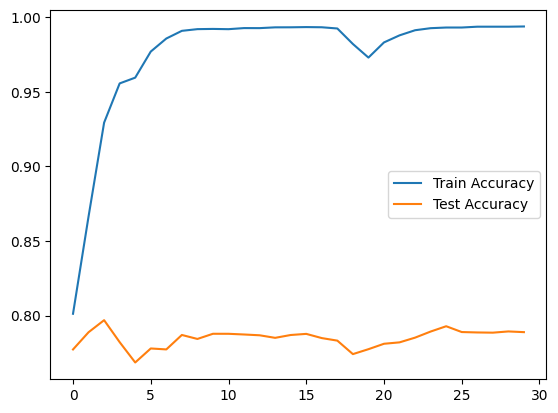

In [21]:
plt.plot(train_acc, label='Train Accuracy')
plt.plot(test_acc, label='Test Accuracy')
plt.legend()
plt.show()

In [22]:
train_acc = accuracy(model, train_batch)
test_acc = accuracy(model, test_batch)

print('Train:', train_acc,'Test:', test_acc)

Train: [0.9898785425101214, 0.9918200408997955, 0.9979550102249489, 0.9959266802443992, 0.9959016393442623, 0.9959432048681541, 0.9897540983606558, 0.9958847736625515, 0.997946611909651, 0.9852631578947368, 0.9938398357289527, 1.0, 0.9958932238193019, 0.9938775510204082, 0.9938271604938271, 1.0, 0.9916839916839917, 0.9959266802443992, 0.9938144329896907, 0.9959432048681541, 0.9979838709677419, 0.9917184265010351, 0.991701244813278, 1.0, 0.9896694214876033, 0.9958847736625515, 0.9958932238193019, 1.0, 0.9938524590163934, 0.9979838709677419, 0.9958762886597938, 0.9918864097363083, 0.9898373983739838, 0.9958677685950413, 0.9938271604938271, 0.9918200408997955, 0.9896049896049897, 0.9979633401221996, 0.9917525773195877, 0.9937888198757764, 0.9917184265010351, 0.995850622406639, 0.9918032786885246, 0.9958847736625515, 0.9918533604887984, 0.997946611909651, 0.99375, 0.9898167006109979, 0.9938398357289527, 0.9835728952772074, 0.9959016393442623, 0.9897119341563786, 0.9958847736625515, 0.99173

In [ ]:

def predict(model, text, preprocessor):
    labels = ['Negative', 'Positive']
    des_vec, length = preprocessor.description_to_vector(text)
    padded_res = preprocessor.vector_padding(des_vec)
    padded_res = padded_res.unsqueeze(0)
    res = model(padded_res.cuda())
    forward = torch.argmax(F.softmax(res, dim=1), dim=1)
    return labels[forward]
    
predict(model, 'hello how are you this movie is really good i like this', preprocessor)

In [24]:
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save('save_path') # Save
